### Overall Approach

1. Train a model which can predict the price of gas needed by the StorageMarketActor, based on input factors.
2. With that model, we can then run MechaFIL for various FIL+ rates (which translates to differing amounts of 
   FIL+ data onboarded).
   a. For each FIL+ rate, we can use the model to determine the amount of gas needed to onboard the forecasted amount of deal power.
   b. Compare that to the circulating supply statistics in order to determine the current impact.
3. Next, estimate the change in gas usage due to DirectFIL+.
4. Re-run the forecasts and compare.

*Note: If 2b is very small, then from a CE perspective, it may be irrelevant how much gas is saved by DirectFIL+.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
import pandas as pd
import sqlalchemy as sqa

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil.data as d
import mechafil.data_spacescope as dss
import scenario_generator.utils as u
import cel_utils.disk_utils as du

In [3]:
save_dir = os.path.join(os.environ['HOME'], 'Documents', 'direct_filp')
offline_dir = os.path.join(save_dir, 'offline')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_dir, exist_ok=True)

In [4]:
sso = dss.SpacescopeDataConnection('/Users/kiran/code/auth/kiran_spacescope_auth.json')

In [5]:
## Data Query Methods
def get_storage_market_gas_data_lily():
    # Define the height of the blockchain from which the data should be taken
    HEIGHT=2_000_000
    ACTOR='storagemarket'
    FILECOIN_GENESIS_UNIX_EPOCH = 1598306400
    
    with open('/Users/kiran/code/auth/lily.txt') as f:
        secretString = f.read()
    
    # Try to create a connection to the database
    try:
        # Define an engine using the connection string
        engine = sqa.create_engine(secretString)
        # Establish a connection to the database
        conn = engine.connect()
    # If the connection fails, catch the exception and print an error message
    except Exception as e:
        print("Failed to connect to database")
        # Propagate the error further
        raise(e)
        
    QUERY_1 = f'''
         SELECT height, SUM(gas_used) 
         FROM "visor"."derived_gas_outputs"
         WHERE height > {HEIGHT} AND actor_family='{ACTOR}'
         GROUP BY height
         ORDER BY height ASC
     '''
    df_sm_gas = pd.read_sql(sql=sqa.text(QUERY_1), con=conn)
    df_sm_gas['time'] = pd.to_datetime(df_sm_gas['height'].values*30 + FILECOIN_GENESIS_UNIX_EPOCH, unit='s')
    
    # sum gas over each day
    gas_daily_lily = df_sm_gas.groupby(df_sm_gas['time'].dt.date)['sum'].sum()
    return gas_daily_lily

def get_storage_market_gas_data_mercury():
    

def get_storage_market_gas_data_starboard(start_date, end_date):
    df_gas = sso.spacescope_query(
        start_date,
        end_date,
        url_template='https://api.spacescope.io/v2/gas/daily_gas_usage_in_units?end_date=%s&start_date=%s'
    )
    df_gas['date'] = pd.to_datetime(df_gas['stat_date']).dt.date
    return df_gas
    
def get_gas_model_training_data(start_date, end_date):
    gas_df = get_storage_market_gas_data_starboard(start_date, end_date)
    df_power_onboard = sso.query_spacescope_daily_power_onboarded(
        start_date,
        end_date
    )
    df_power_cumulative = sso.query_spacescope_power_stats(
        start_date, 
        end_date
    )
    # merge the dataframes
    training_df = pd.merge(gas_df, df_power_onboard, on='date', how='outer')
    training_df = pd.merge(training_df, df_power_cumulative, on='date', how='outer')
    return training_df

### Step 1
Here, we verify that aggregate gas data coming from spacescope is the same as pulling the data from Lily.
Specifically, from Lily, we can get all of the gas used by the StorageMarketActor, which is necessary to use
to make FIL+ deals currently, but will be deprecated with DirectFIL+.

In [ ]:
# pull data from lily and spacescope
gas_daily_lily = get_storage_market_gas_data_lily()

start_date = pd.to_datetime(gas_daily_lily.index[0]).date()
end_date = pd.to_datetime(gas_daily_lily.index[-1]).date()
df_gas = get_storage_market_gas_data_starboard(start_date, end_date)

In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
# plt.plot(fil_stats_df['date'], fil_stats_df['burnt_fil'].diff(), label='Spacescope')
plt.plot(gas_daily_lily.index, gas_daily_lily*1e-9, label='Lily')
plt.plot(pd.to_datetime(df_gas['stat_date']).dt.date, df_gas['publish_storage_deals_gas_used']*1e-9, label='PSD-SS')

plt.xticks(rotation=60)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(gas_daily_lily.iloc[1:]*1e-9, df_gas['publish_storage_deals_gas_used']*1e-9)
plt.xlabel('Lily')
plt.ylabel('Starboard')

plt.suptitle('Comparison of StorageMarketActor Gas Data from Lily & Starboard')
plt.tight_layout()

### Step 2
Create a model that can predict the gas cost for onboarding X PiB of Deal Power for a given day

In [6]:
start_date = date(2021, 3, 15)
end_date = date.today() - timedelta(days=3)
tdf = get_gas_model_training_data(start_date, end_date)
tdf = tdf.dropna()

# convert from gas units to FIL
gas_cols = ['total_gas_used', 'provecommit_sector_gas_used', 'precommit_sector_gas_used', 
            'provecommit_aggregate_gas_used', 'precommit_sector_batch_gas_used',
            'publish_storage_deals_gas_used', 'submit_windowed_post_gas_used'
           ]
for g in gas_cols:
    tdf[g] = tdf[g]*1e-9

tdf.head()

,stat_date,total_gas_used,provecommit_sector_gas_used,precommit_sector_gas_used,provecommit_aggregate_gas_used,precommit_sector_batch_gas_used,publish_storage_deals_gas_used,submit_windowed_post_gas_used,date,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,total_raw_power_eib,total_qa_power_eib
0,2021-03-15T00:00:00Z,48762.141121,36928.125727,10961.072770,0.0,0.0,62.401345,761.421464,2021-03-15,30.778351,30.809411,3.281365,3.282306
1,2021-03-16T00:00:00Z,48336.123637,36245.996815,11308.001418,0.0,0.0,15.689558,718.467517,2021-03-16,30.751831,30.778159,3.310809,3.311754
2,2021-03-17T00:00:00Z,49781.895871,37128.165375,11881.030286,0.0,0.0,64.483731,654.003619,2021-03-17,31.845703,31.854920,3.341048,3.341986
3,2021-03-18T00:00:00Z,48615.549721,36524.507337,11350.775977,0.0,0.0,36.421924,653.083039,2021-03-18,31.429504,31.464130,3.369592,3.370540
4,2021-03-19T00:00:00Z,48216.082456,36013.169739,11431.087854,0.0,0.0,65.288968,661.734185,2021-03-19,31.384003,31.454148,3.396884,3.397818


<IPython.core.display.Javascript object>


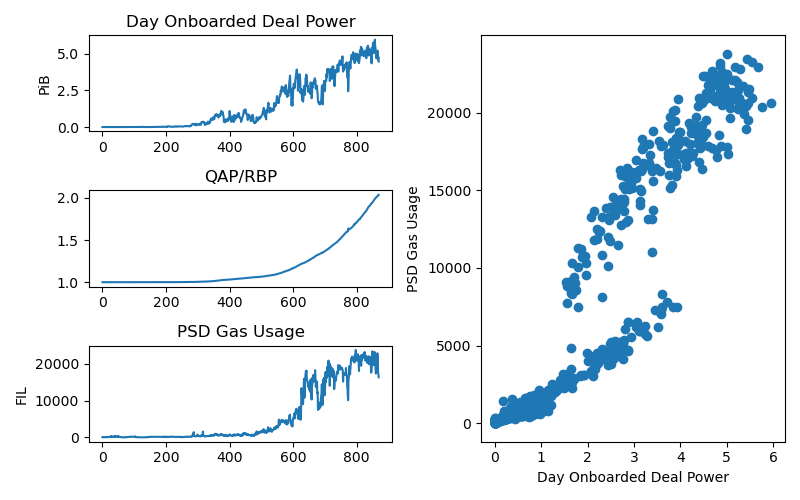

In [7]:
# Explore the features we wish to use for this model

# the features we care about are onboarding FIL+ rate, and the amount of deal onboarded power
# TODO: we can experiment with others
tdf['day_onboarded_deal_power'] = (tdf['day_onboarded_qa_power_pib'] - tdf['day_onboarded_rb_power_pib'])/9
tdf['network_qa_rb_ratio'] = tdf['total_qa_power_eib'] / tdf['total_raw_power_eib']
# the prediction target is in the column: 'publish_storage_deals_gas_used'

# plot these quantities to get a sense for whether these features seem reasonable
fig = plt.figure(figsize=(8,5))
spec = fig.add_gridspec(3,2)

ax = fig.add_subplot(spec[0,0])
ax.plot(tdf['day_onboarded_deal_power'])
ax.set_title('Day Onboarded Deal Power')
ax.set_ylabel('PiB')

ax = fig.add_subplot(spec[1,0])
ax.plot(tdf['network_qa_rb_ratio'])
ax.set_title('QAP/RBP')

ax = fig.add_subplot(spec[2,0])
ax.plot(tdf['publish_storage_deals_gas_used'])
ax.set_title('PSD Gas Usage')
ax.set_ylabel('FIL')

ax = fig.add_subplot(spec[:,1])
ax.scatter(tdf['day_onboarded_deal_power'], tdf['publish_storage_deals_gas_used'])
ax.set_xlabel('Day Onboarded Deal Power')
ax.set_ylabel('PSD Gas Usage')

plt.tight_layout()

From the above figure, we observe the following:
1. Day Onboarded Deal Power and PSD Gas Usage seem to be correlated strongly.
2. However, there seem to be 2 "regimes" of relationship: 
    * When the QAP/RBP ratio is low
    * When the QAP/RBP ratio is high

A simple, starting approach, could be to:
1. Have a model which determines which "regime" we are in
2. Within each regime, we then apply linear regression to forecast gas cost, given the input features.

#### Step 2A

*Regime Model*
This model determines which "regime" we are in, essentially selecting which linear regression model will be run to forecast gas cost for using the StorageMarketActor.

There are several approaches to this. If we are convinced that the QAP/RBP is a good heuristic for regime, then we could try to find a threshold. Another approach is, from the scatter plot above, we see two distinct clusters. We could simply classify points into two clusters.

The following set of steps uses the clustering approach to build a "regime" classification model.

In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression

X = tdf[['day_onboarded_deal_power', 'publish_storage_deals_gas_used']]
regime_clustering_model = GaussianMixture(n_components=2, random_state=0).fit(X)

cluster_labels = regime_clustering_model.predict(X)

<IPython.core.display.Javascript object>


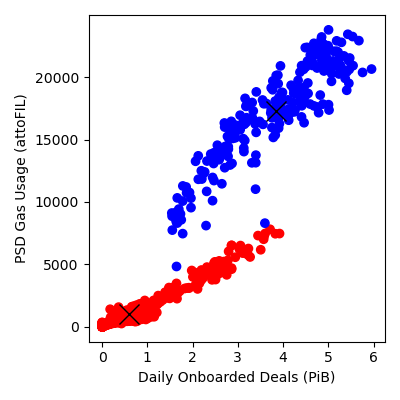

In [9]:
# plot clustering results
plt.figure(figsize=(4,4))

cvec = ['r' if l == 1 else 'b' for l in cluster_labels]
plt.scatter(tdf['day_onboarded_deal_power'], tdf['publish_storage_deals_gas_used'], color=cvec)
plt.plot(regime_clustering_model.means_[0,0], regime_clustering_model.means_[0,1], 
         color='k', marker='x', markersize=15)
plt.plot(regime_clustering_model.means_[1,0], regime_clustering_model.means_[1,1], 
         color='k', marker='x', markersize=15)
plt.xlabel('Daily Onboarded Deals (PiB)')
plt.ylabel('PSD Gas Usage (attoFIL)')
plt.tight_layout()

The clustering model seems to work OK. Now, lets build a logistic regression model which uses the labels
from the clustering model to take both input features and determine which regime we are in

In [10]:
from sklearn.linear_model import LogisticRegression

X = tdf[['day_onboarded_deal_power', 'network_qa_rb_ratio']]
y = cluster_labels
regime_model = LogisticRegression(random_state=0).fit(X, y)

regime_model.score(X, y)

0.9436781609195403

In [11]:
# Now, lets build regression models to forecast the gas required to onboard PiB of QA power
regression_features = ['day_onboarded_deal_power', 'network_qa_rb_ratio', 'publish_storage_deals_gas_used']

# first, separate out the data
nclusters = 2
models = {}
training_datasets = {}
for i in range(nclusters):
    regime_idx = np.where(cluster_labels==i)[0]
    data_subset = tdf[regression_features].iloc[regime_idx]
    X = data_subset[['day_onboarded_deal_power', 'network_qa_rb_ratio']]
    y = data_subset['publish_storage_deals_gas_used']
    
    # train regression model
    model = LinearRegression().fit(X, y)
    
    models[i] = model
    training_datasets[i] = {
        'X': X,
        'y': y
    }

<IPython.core.display.Javascript object>


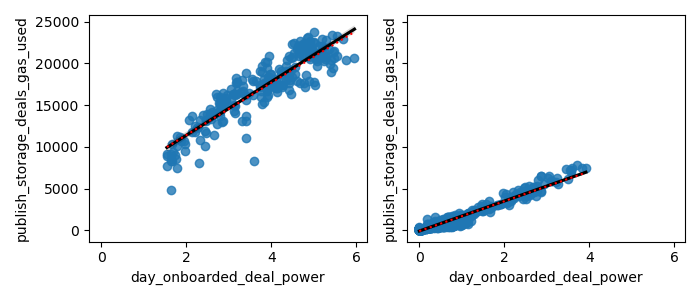

In [12]:
# plot training datasets to ensure we separated the data properly
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(7,3))

# plot only the first feature to keep plot 2d
sns.regplot(x=training_datasets[0]['X']['day_onboarded_deal_power'], 
            y=training_datasets[0]['y'], 
            ax=ax[0], 
            line_kws={'color': 'k'})
# plot the regression line that we learned as a second sanity check
X0 = training_datasets[0]['X']
x0_0 = np.linspace(min(X0['day_onboarded_deal_power']), max(X0['day_onboarded_deal_power']), 100)
x0_1 = np.linspace(min(X0['network_qa_rb_ratio']), max(X0['network_qa_rb_ratio']), 100)
X0 = pd.DataFrame()
X0['day_onboarded_deal_power'] = x0_0
X0['network_qa_rb_ratio'] = x0_1
y_pred = models[0].predict(X0)
ax[0].plot(x0_0, y_pred, color='r', linestyle=':')

# plot only the first feature to keep plot 2d
sns.regplot(x=training_datasets[1]['X']['day_onboarded_deal_power'], 
            y=training_datasets[1]['y'], 
            ax=ax[1], 
            line_kws={'color': 'k'})
# plot the regression line that we learned as a second sanity check
X1 = training_datasets[1]['X']
x1_0 = np.linspace(min(X1['day_onboarded_deal_power']), max(X1['day_onboarded_deal_power']), 100)
x1_1 = np.linspace(min(X1['network_qa_rb_ratio']), max(X1['network_qa_rb_ratio']), 100)
X1 = pd.DataFrame()
X1['day_onboarded_deal_power'] = x1_0
X1['network_qa_rb_ratio'] = x1_1
y_pred = models[1].predict(X1)
ax[1].plot(x1_0, y_pred, color='r', linestyle=':')

plt.tight_layout()

In [13]:
# create a function that wraps both the regime predictor and the gas cost predictor
# TODO: vectorize
def predict_deal_gas_cost(day_onboard_deal_power, network_qa_rb_ratio):
    # first predict the regime
    X_in = pd.DataFrame()
    X_in['day_onboarded_deal_power'] = [day_onboard_deal_power]
    X_in['network_qa_rb_ratio'] = [network_qa_rb_ratio]
    regime = regime_model.predict(X_in)[0]
    
    gas_model = models[regime]
    gas_cost = gas_model.predict(X_in)
    return gas_cost

<IPython.core.display.Javascript object>


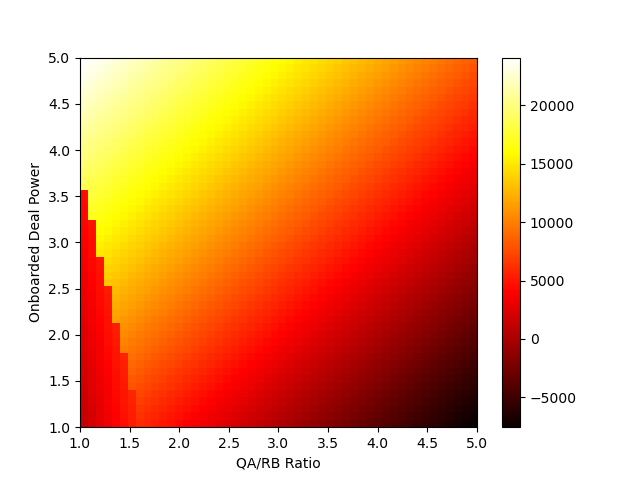

In [14]:
# characterize the gas cost predictor
# characterize the outputs
nx = 50
ny = 50

xmin=1; xmax=5
ymin=1; ymax=5
onboarded_deal_power_vec = np.linspace(xmin,xmax,nx)
qa_rb_ratio_vec = np.linspace(ymin, ymax, ny)

c_mat = np.zeros((nx,ny))
# run the model
for i in range(nx):
    for j in range(ny):
        c_mat[i,j] = predict_deal_gas_cost(onboarded_deal_power_vec[i], qa_rb_ratio_vec[j])

plt.figure()
plt.imshow(c_mat, origin='lower', extent=[ymin,ymax,xmin,xmax], cmap='hot', aspect='auto')
plt.xlabel('QA/RB Ratio')
plt.ylabel('Onboarded Deal Power')
plt.colorbar()

Investigate why there are some negative gas cost predictions. Is it b/c the regression wasn't trained in this range of data, or something else?

### Step 3
Simulate various levels of Deal power onboarding and compute circulating supply w/ MechaFIL.
Compute statistics on the ratio of Gas to Circulating Supply to understand the impact

In [15]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
lock_target = 0.3
forecast_length = 365*3
sector_duration = 540
start_date = date(2023, 7, 1)
current_date = date(2023,7,31)
end_date = current_date + timedelta(days=forecast_length)

In [16]:
@du.cache_data(save_dir)
def get_offline_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    
    return {
        'offline_data': offline_data,
        't_hist_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_hist_rr': t_hist_rr,
        'hist_rr': hist_rr,
        't_hist_fpr': t_hist_fpr,
        'hist_fpr': hist_fpr
    }

od = get_offline_data()
locals().update(od)

In [17]:
smooth_historical_rbp = np.median(hist_rbp[-90:])
smooth_historical_rr = np.median(hist_rr[-90:])

In [18]:
def estimate_gas_cost_for_fpr(fpr_val, results_dict):
    fpr_forecast = jnp.ones(forecast_length)*fpr_val
    hist_start_idx = np.where(pd.to_datetime(t_hist_fpr).dt.date == start_date)[0][0]
    hist_end_idx = np.where(pd.to_datetime(t_hist_fpr).dt.date == current_date)[0][0]
    
    fpr_hist_subset = hist_fpr[hist_start_idx:hist_end_idx]
    fpr_full = np.concatenate([fpr_hist_subset, fpr_forecast])
    
    # qa = rb*(1-fpr) + rb*10*fpr
    day_onboarded_rb_power = np.asarray(results_dict['rb_day_onboarded_power_pib'])
    day_onboarded_qa_power = np.asarray(results_dict['qa_day_onboarded_power_pib'])
    day_onboarded_deal_power = (day_onboarded_qa_power-day_onboarded_rb_power)/9.0
    qa_rb_ratio = np.asarray(results_dict['network_QAP_EIB']/results_dict['network_RBP_EIB'])
    
    gas_cost_vec = []
    for ii in range(len(day_onboarded_deal_power)):
        gc = predict_deal_gas_cost(day_onboarded_deal_power[ii], qa_rb_ratio[ii])
        gas_cost_vec.append(gc[0])
    return np.asarray(gas_cost_vec)

In [22]:
# connect MechaFIL
# for a given FIL+ rate, we can estimate the gas costs of using the status-quo.
# we can compute that as a % of Circ-Supply
# then, we make an assumption on gas savings as a result of direct FIL+
# we then assess at various adoption levels over time, what the impact to CS will be
fpr_onboarding_scenarios = [0.5, 0.75, 1.0]
results_dict = {}
for fpr_val in fpr_onboarding_scenarios:
    rbp = jnp.ones(forecast_length) * smooth_historical_rbp
    rr = jnp.ones(forecast_length) * smooth_historical_rr
    fpr = jnp.ones(forecast_length) * fpr_val

    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simulation_results['cum_outflow'] = simulation_results['network_gas_burn'] + simulation_results['network_locked']
    simulation_results['cum_inflow'] = simulation_results['total_vest'] + simulation_results['cum_network_reward']
    simulation_results['cum_netflow'] = simulation_results['cum_inflow'] - simulation_results['cum_outflow']
    simulation_results['netflow'] = jnp.diff(simulation_results['cum_netflow'])
    simulation_results['day_outflow'] = jnp.diff(simulation_results['cum_outflow'])

    gas_cost = estimate_gas_cost_for_fpr(fpr_val, simulation_results)
    simulation_results['day_deal_gas_cost'] = gas_cost
    # NOTE: this is a major assumption that needs to be better dealt with.
    simulation_results['day_deal_gas_cost_directfilp'] = gas_cost*0.15
    
    results_dict[fpr_val] = simulation_results

In the above, notice that `day_deal_gas_cost_directfilp` is just defined statically as 15% of the gas cost of messaging w/ StatusQuo-FIL+.  15% was derived from the initial GitHub specification, but we need to get a better method of assessing this.

In [23]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

<IPython.core.display.Javascript object>


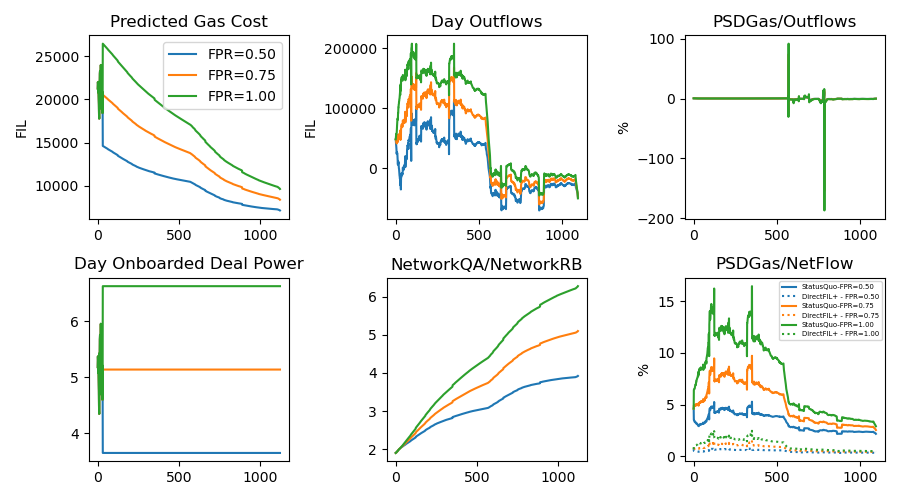

In [31]:
plt.figure(figsize=(9,5))

plt.subplot(2,3,1)
for fpr_val in fpr_onboarding_scenarios:
    r = results_dict[fpr_val]
    plt.plot(r['day_deal_gas_cost'], label='FPR=%0.02f' % (fpr_val,))
plt.title('Predicted Gas Cost')
plt.ylabel('FIL')
plt.legend()

plt.subplot(2,3,2)
for fpr_val in fpr_onboarding_scenarios:
    r = results_dict[fpr_val]
    day_outflow_smooth = moving_average(np.asarray(r['day_outflow']),30)
    plt.plot(day_outflow_smooth, label='FPR=%0.02f' % (fpr_val,))
plt.title('Day Outflows')
plt.ylabel('FIL')

plt.subplot(2,3,3)
for fpr_val in fpr_onboarding_scenarios:
    r = results_dict[fpr_val]
    plt.plot(r['day_deal_gas_cost'][30:]/day_outflow_smooth, label='FPR=%0.02f' % (fpr_val,))
plt.title('PSDGas/Outflows')
plt.ylabel('%')


plt.subplot(2,3,4)
for fpr_val in fpr_onboarding_scenarios:
    r = results_dict[fpr_val]
    day_onboarded_rb_power = np.asarray(r['rb_day_onboarded_power_pib'])
    day_onboarded_qa_power = np.asarray(r['qa_day_onboarded_power_pib'])
    x = (day_onboarded_qa_power-day_onboarded_rb_power)/9.0
    plt.plot(x, label='FPR=%0.02f' % (fpr_val,))
plt.title('Day Onboarded Deal Power')

plt.subplot(2,3,5)
for fpr_val in fpr_onboarding_scenarios:
    r = results_dict[fpr_val]
    plt.plot(r['network_QAP_EIB']/r['network_RBP_EIB'], label='FPR=%0.02f' % (fpr_val,))
plt.title('NetworkQA/NetworkRB')

plt.subplot(2,3,6)
for fpr_val in fpr_onboarding_scenarios:
    r = results_dict[fpr_val]
    netflow_smooth = moving_average(np.asarray(r['netflow']),30)
    p = plt.plot(r['day_deal_gas_cost'][30:]/netflow_smooth * 100, label='StatusQuo-FPR=%0.02f' % (fpr_val,))
    plt.plot(r['day_deal_gas_cost_directfilp'][30:]/netflow_smooth * 100, label='DirectFIL+ - FPR=%0.02f' % (fpr_val,),
             color=p[0].get_color(), linestyle=':')
plt.title('PSDGas/NetFlow')
plt.ylabel('%')
plt.legend(fontsize=5)

plt.tight_layout()